# <center> Simulación de Gases de Lennard-Jones *Reversible* 

El potencial de Lennard-Jones entre dos partículas $i, j$ separadas una distancia $r_{ij}$ es:

$$ U_{LJ}(r_{ij}) = 4\epsilon \left[ \left( \frac{\sigma}{r_{ij}} \right)^{12} - \left( \frac{\sigma}{r_{ij}} \right)^6 \right] $$

Y la fuerza asociada es:

$$ \vec F_{LJ}(r_ij) = -\nabla U_{LJ}(r_{ij}) = -48\epsilon \left[ \left( \frac{\sigma}{r_{ij}} \right)^{12} - \frac{1}{2}\left( \frac{\sigma}{r_{ij}} \right)^6 \right] \frac{\vec r_{ij}}{r_{ij}} $$

Para evitar calculos poco relevantes para distancias largas se utiliza un **potencial truncado** suavemente a una distancia crítica **$r_c$**:

$$ U(r) = \left\{ 	
    \begin{array}{ll}
        U_{LJ}(r) - U_{LJ}(r_c) + 48\epsilon \left[ \left( \frac{\sigma}{r_{ij}} \right)^{12} - \frac{1}{2}\left( \frac{\sigma}{r_{ij}} \right)^6 \right] \frac{r_-r_c}{r_c}  
        & \mbox{if } r < r_c \\
		0 & \mbox{if } r \geq r_c
	\end{array}  
\right.
$$

$$ \vec F(r) = \left\{ 	
\begin{array}{ll}
48\epsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \frac{1}{2}\left( \frac{\sigma}{r} \right)^6 \right] \frac{\hat r}{r^2}
-
48\epsilon \left[ \left( \frac{\sigma}{r_c} \right)^{12} - \frac{1}{2}\left( \frac{\sigma}{r_c} \right)^6 \right] \frac{\hat r}{r\ r_c}
  & \mbox{if } r < r_c \\
		\vec 0 & \mbox{if } r \geq r_c
	\end{array}  
\right.
$$

### Algoritmo de Levesque-Verlet

$$ r_i(t+\Delta t) = - r_i(t-\Delta t) + 2r_i(t) + \frac{(\Delta t)^2}{m} \vec F (\vec r (t)) + \mathcal{O}((\Delta t ^3)) $$

discretizando

$$ r_{i_{n+1}} = - r_{i_{n-1}} + 2r_{i_n} + \frac{h^2}{m}  F_i(\vec r_n)  + \mathcal{O}(h^3) $$ 

#### Variables adimensionales

$$ R = r\ /\ \sigma $$

$$ T = t\ /\ t_o = n\Delta t\ /\ t_o = nh$$

$$ t_o = \sigma \sqrt{m \ /\ \epsilon} $$

$$ R_c = 2.5 $$

$$ h = 0.005 $$

##### Para $R < R_c$

$$ \vec F_{adimensional} = (\sigma \ /\ \epsilon)\vec F (\vec R) = 48 \left\{ \left(\frac{1}{R}\right)^{13} - \left(\frac{1}{R}\right)^{7} - \left[ \left(\frac{1}{R_c}\right)^{13} - \frac{1}{2}\left(\frac{1}{R_c}\right)^{7} \right] \right\} \frac{\vec R}{R} $$

$$ \vec R (n+1) = \vec R(n-1) +2\vec R(n) - h^2 \vec F_{ad} (R(n)) $$

In [11]:
using ODE, PyPlot, Colors, Distributions

Para este problema, necesitamos simular una caja de lado $L$ pero, como los números tipo `Float64` hacen operaciones de redondéo ya que difícilmente exísten en la representación binaria, se hará una transfórmación de la caja hacia una retícula en los enteros `Int64`.

Para sistemas en el espacio libre, ie, $L \to \infty$, recurriremos al truco de **implementar fronteras periodicas**.

In [140]:
const L = 10. #100*2.5 # R_c = 2.5

10.0

## Transformación a los Enteros

Notemos los siguientes *detalles* sobre trabajar con enteros muy grandes ($\sim 2^{64}$)

In [20]:
2 ^ 64 #Ya no es representable por un Int64

0

In [21]:
2 ^ 63 #Tiene problemas de respresentación ya que un bit trabaja con el signo

-9223372036854775808

In [30]:
2000 * (2^62)

0

Aún cuando $2^{62}$ ya es representable como un `Int64`, si el cálculo a priori a la transformación `Float`$\to$ `Int` excede la máxima representación fiel de los tipo `Int64`, el resultado no será correcto.

Debemos dar un espacio de cálculos. Así, la transformación a enteros o, visto en términos físicos, la resolución de cuadrícula de la caja debe ser un poquito menos refinada que $2^{62}$ para que podamos representar cualquier número calculado en las fuerzas del problema.

In [141]:
const flt_to_int = 2^60

1152921504606846976

In [45]:
10.13* flt_to_int , typeof(10.13* flt_to_int) # 10.13 es un número de prueba nada más

(2.91977371041684e18,Float64)

In [47]:
Int64(10.13 * flt_to_int) , typeof(Int64(2. * flt_to_int))

(2919773710416840192,Int64)

In [48]:
Int64(10.13 * flt_to_int) == 10.13* flt_to_int

true

In [137]:
 flotante_a_entero2(flotante::Float64) = Int64(flotante * flt_to_int / L)

flotante_a_entero2 (generic function with 1 method)

### Algo aquí no funciona

In [129]:
ceil(Int64,5.5) === Int64(ceil(5.5))

true

In [130]:
function flotante_a_entero(flotante:: Float64, lado_caja::Float64, cajitas::Int64 = 2^60)
#    ceil(Int64,cajitas*flotante/lado_caja)
    Int64(ceil(cajitas*flotante/lado_caja))
end

flotante_a_entero (generic function with 4 methods)

In [131]:
flotante_a_entero(10.0*rand(), 10.0) #El flotante debería ser menor al lado de la caja.

447547723285192704

In [132]:
#Buscando el error
ladin = 10.0
cajitas = 2^60
caso1 = 0.5e-17  #límite inferior
caso2 = 8.0ladin #límite superior: Sube si se consideran menos cajas, i.e. 2^58
# 8.0 == 2^3 -> 8*2^60 = 2^63 que ya no es fielmente representable ∴ marca error al intentar convertirlo.
flotante_a_entero(caso2, ladin, cajitas)

LoadError: LoadError: InexactError()
while loading In[132], in expression starting on line 6

In [163]:
# Versión para arreglos
function flotante_a_entero(vector_flotante::Vector{Float64}, lado_caja::Float64, cajitas::Int64 = 2^60)
    
    largo = length(vector_flotante)
    vector_entero = Vector{Int64}(largo)
    
    for (i,flotante) in enumerate(vector_flotante)
#         vector_entero[i] = Int64(cajitas*flotante/lado_caja)  #Por alguna razón esto falla si flotante/lado_caja <= 0.01
        vector_entero[i] = flotante_a_entero(flotante,lado_caja,cajitas)
    end
    vector_entero
end

flotante_a_entero (generic function with 4 methods)

In [164]:
bubu = randn(5).+5.0
flotante_a_entero(bubu,10.0)

5-element Array{Int64,1}:
 704418759394030208
 629432898167448832
 463666447069872448
 386645376583933184
 572455518170391424

#### Entero a flotante

In [165]:
function entero_a_flotante(entero:: Int64,lado_caja::Float64, cajitas::Int64 = 2^60)
    Float64(entero*lado_caja/cajitas) #Por alguna razón el poner Float64() cambia los resultados...
end

entero_a_flotante (generic function with 4 methods)

In [166]:
# Verión para arreglos
function entero_a_flotante(vector_entero:: Vector{Int64},lado_caja::Float64, cajitas::Int64 = 2^60)
    largo = length(vector_entero)
    vector_flotante = Vector{Float64}(largo)
    
    for (i,entero) in enumerate(vector_entero)
        #         vector_flotante[i] = Float64(entero*lado_caja/cajitas)  #Esto resulta en algo inesperado... :(
        vector_flotante[i] = entero_a_flotante(entero,lado_caja,cajitas)
    end
    vector_flotante
end

entero_a_flotante (generic function with 4 methods)

In [167]:
bubu = rand(1000000000:10000000000,5)
entero_a_flotante(bubu,1.0)

5-element Array{Float64,1}:
 6.37648e-9
 2.30101e-9
 7.25741e-9
 2.33614e-9
 3.88601e-9

### Distribución inicial

Dada una distribución inicial se generan movimientos aleatorios con una distribución gaussiana para obtener la siguiente distribución, por lo que las velocidades también tienen una distribución gaussiana. La desviación estandar de esta está relacionada con la temperatura.

In [168]:
using Distributions

In [169]:
function fluctuacion_gaussiana(X_0, media = 0.0, desv_std = 0.1)
    largo = length(X_0)
    distribucion = Normal(media, desv_std)
    fluctuaciones = rand(distribucion, largo)
    X_0 + fluctuaciones
end

fluctuacion_gaussiana (generic function with 3 methods)

In [170]:
fluctuacion_gaussiana(rand(12));

### Division de la caja en zonas de lado $r_c$

Vamos a implementar el teselador dentro de la función que calcula las fuerzas para tomar en cuenta la periodicidad de las fronteras.

#### Un comportamiento extraño...

In [171]:
cajma = 2^50

1125899906842624

In [172]:
ceil(cajma/3) - cajma/3 #Parece que hacer ceil trae problemas... 

0.6875

In [173]:
cajma % 3 # 2^50 no es divisible entre 3, hay que cuidar la jerarquía de operaciones 

1

In [174]:
Int64(3*cajma/3)

1125899906842624

In [175]:
3*Int64(ceil(cajma/3))

1125899906842626

In [176]:
3*Int64(ceil(cajma/3)) - cajma

2

In [177]:
.6875 * 3 #Parece que esto es lo que hace la diferencia en las conversiones

2.0625

In [178]:
function teselador_mat(coordenadas::Vector{Int64}, divisiones::Int64, cajitas::Int64 = 2^60)  #De entrada en enteros.
      
    #rc_entero = Int64(ceil(cajitas/divisiones)) #El radio crítico en unidades de cajitas (2^60 enteros) 
    rc_entero = cld(cajitas, divisiones)
    rango = 1:divisiones
    zonas = [Int64[] for i = rango, j = rango, k = rango]
    
    largo = length(coordenadas)
    
    for i in 3:3:largo
        xn = Int64(ceil(coordenadas[i-2] / rc_entero))
        yn = Int64(ceil(coordenadas[i-1] / rc_entero))
        zn = Int64(ceil(coordenadas[i]   / rc_entero))
        push!(zonas[xn,yn,zn],i)
    end
    zonas
end

teselador_mat (generic function with 2 methods)

In [179]:
# ¡Funciona!
coord = rand(1:10,30)
div   = 2
caj   = 10
teselador_mat(coord,div,caj)  #Matrices

LoadError: LoadError: UndefVarError: coord not defined
while loading In[179], in expression starting on line 1

#### Prueba de tiempo (matriz vs. diccionario)

In [421]:
collect(linspace(3,300000,100));

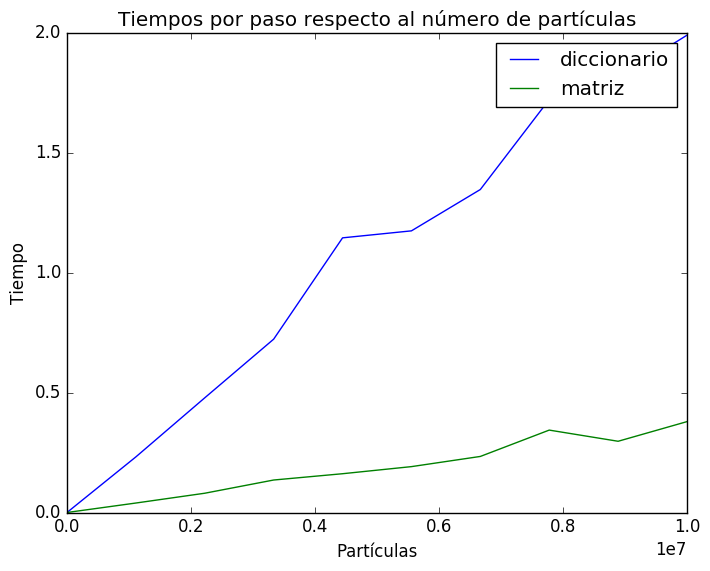

PyObject <matplotlib.legend.Legend object at 0x7f73ca23d6d0>

In [422]:
div = 2
caj = 10
reg_dic = []
reg_mat = []
range = linspace(3,30000000,10)
for M in range
    coord = rand(1:10,Int64(M))
    tiempo_dic = @elapsed(teselador_dic(coord,div,caj))
    tiempo_mat = @elapsed(teselador_mat(coord,div,caj))
    push!(reg_dic,tiempo_dic)
    push!(reg_mat,tiempo_mat)
end
plot(range/3,reg_dic, label = "diccionario")
plot(range/3,reg_mat, label = "matriz")
title("Tiempos por paso respecto al número de partículas")
xlabel("Partículas")
ylabel("Tiempo")
legend()

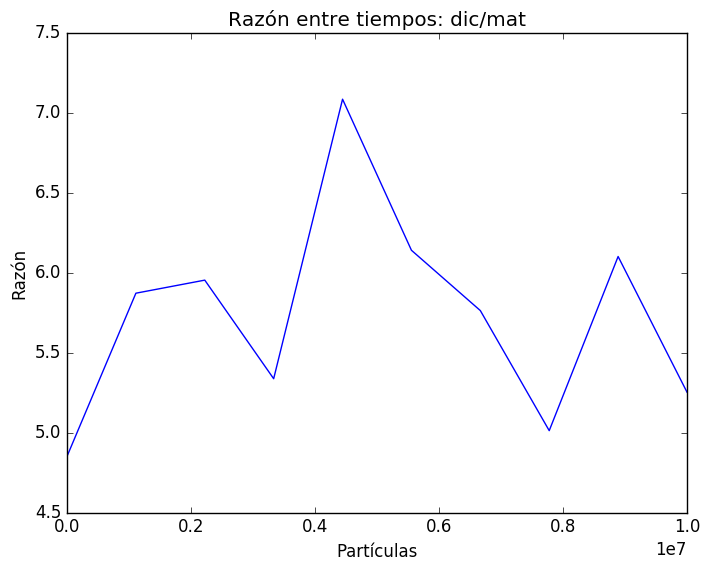

PyObject <matplotlib.text.Text object at 0x7f73ca1076d0>

In [423]:
plot(range/3, reg_dic./reg_mat)
title("Razón entre tiempos: dic/mat")
xlabel("Partículas")
ylabel("Razón")

#### ¡La matriz es la ganadora!

### Ahora la función que relacionara las zonas con sus vecinos más cercanos (en 3D son 7).

In [255]:
### Aunque esto es más corto es conveniente usar muchos if porque calcular modulos constantemente puede tardar...
function vecinos_mod{T<:Int64}(zonas::Array{Vector{T},3}, i::T, j::T, k::T)

    imax, jmax, kmax = size(zonas)

    i_plus = mod1(i+1, imax)
    j_plus = mod1(j+1, jmax)
    k_plus = mod1(k+1, kmax)
    
#     vecindad = zonas[i,j,k]  #Incluyendo la zona inicial.
    vecindad = Int64[]  #Incluyendo sólo a los vecinos de la zona inicial.
    
    append!(vecindad, zonas[i_plus, j, k])
    append!(vecindad, zonas[i, j_plus, k])
    append!(vecindad, zonas[i_plus, j_plus, k])
    append!(vecindad, zonas[i, j, k_plus])
    append!(vecindad, zonas[i, j_plus, k_plus])
    append!(vecindad, zonas[i_plus, j, k_plus])
    append!(vecindad, zonas[i_plus, j_plus, k_plus])
    vecindad
end

vecinos_mod (generic function with 1 method)

In [256]:
function vecinos{T<:Int64}(zonas::Array{Vector{T},3}, i::T, j::T, k::T)
    
    imax, jmax, kmax = size(zonas)
#         vecindad = zonas[i,j,k]  #Incluyendo la zona inicial.
    vecindad = Int64[]  #Incluyendo sólo a los vecinos de la zona inicial.
    
    if i == imax
        append!(vecindad, zonas[1,j,k])
        
        if j == jmax
            append!(vecindad, zonas[i,1,k])
            append!(vecindad, zonas[1,1,k])
            
            if k == kmax 
                append!(vecindad, zonas[i,j,1])
                append!(vecindad, zonas[i,1,1])
                append!(vecindad, zonas[1,j,1])
                append!(vecindad, zonas[1,1,1])
            else
                append!(vecindad, zonas[i,j,k+1])
                append!(vecindad, zonas[i,1,k+1])
                append!(vecindad, zonas[1,j,k+1])
                append!(vecindad, zonas[1,1,k+1])
            end
        else
            append!(vecindad, zonas[i,j+1,k])
            append!(vecindad, zonas[1,j+1,k])
            
            if k == kmax 
                append!(vecindad, zonas[i,j,1])
                append!(vecindad, zonas[i,j+1,1])
                append!(vecindad, zonas[1,j,1])
                append!(vecindad, zonas[1,j+1,1])
            else
                append!(vecindad, zonas[i,j,k+1])
                append!(vecindad, zonas[i,j+1,k+1])
                append!(vecindad, zonas[1,j,k+1])
                append!(vecindad, zonas[1,j+1,k+1])
            end
            
        end
    else
        append!(vecindad, zonas[i+1,j,k])
        
        if j == jmax
            append!(vecindad, zonas[i,1,k])
            append!(vecindad, zonas[i+1,1,k])
            
            if k == kmax 
                append!(vecindad, zonas[i,j,1])
                append!(vecindad, zonas[i,1,1])
                append!(vecindad, zonas[i+1,j,1])
                append!(vecindad, zonas[i+1,1,1])
            else
                append!(vecindad, zonas[i,j,k+1])
                append!(vecindad, zonas[i,1,k+1])
                append!(vecindad, zonas[i+1,j,k+1])
                append!(vecindad, zonas[i+1,1,k+1])
            end
        else
            append!(vecindad, zonas[i,j+1,k])
            append!(vecindad, zonas[i+1,j+1,k])
            
            if k == kmax
                append!(vecindad, zonas[i,j,1])
                append!(vecindad, zonas[i,j+1,1])
                append!(vecindad, zonas[i+1,j,1])
                append!(vecindad, zonas[i+1,j+1,1])
            else
                append!(vecindad, zonas[i,j,k+1])
                append!(vecindad, zonas[i,j+1,k+1])
                append!(vecindad, zonas[i+1,j,k+1])
                append!(vecindad, zonas[i+1,j+1,k+1])
            end
            
        end
    end
    vecindad
end

vecinos (generic function with 1 method)

In [257]:
#Parece ser que sí funciona

coord = rand(1:15,100) 
div = 3
caj = 15
buse = teselador_mat(coord,div,caj)
buse

3x3x3 Array{Array{Int64,1},3}:
[:, :, 1] =
 Int64[]  [69,87,96]  [27]   
 [24]     [51,72]     [66,78]
 [57]     Int64[]     [15]   

[:, :, 2] =
 Int64[]  Int64[]  [75]   
 [90,93]  [9,42]   Int64[]
 Int64[]  [99]     [63]   

[:, :, 3] =
 [12,39]       [36]  [21]     
 [6,18,54,84]  [45]  [81]     
 [33]          [30]  [3,48,60]

In [258]:
vecinos(buse, 1,1,1)

10-element Array{Int64,1}:
 24
 69
 87
 96
 51
 72
 90
 93
  9
 42

In [259]:
vecinos_mod(buse, 1,1,1)

10-element Array{Int64,1}:
 24
 69
 87
 96
 51
 72
 90
 93
  9
 42

#### Es mejor la versión larga, pero si no hay mucha diferencia podría usarse la versión con módulo, es más fácil de leer.

In [232]:
@timev for i in 1:10000000
    vecinos(buse, 1,1,1) 
end

  2.298799 seconds (30.00 M allocations: 1.788 GB, 8.21% gc time)
elapsed time (ns): 2298798949
gc time (ns):      188629004
bytes allocated:   1920000000
pool allocs:       30000000
GC pauses:         84


In [233]:
@timev for i in 1:10000000
    vecinos_mod(buse, 1,1,1)
end

  2.828947 seconds (30.00 M allocations: 1.788 GB, 6.61% gc time)
elapsed time (ns): 2828946866
gc time (ns):      187005615
bytes allocated:   1920000000
pool allocs:       30000000
GC pauses:         84


### Cálculo de la fuerza intermolecular entre una zona y sus vecinos (incluyendola a ella misma)

In [424]:
function fuerza(r::Float64, r_c::Float64 = 2.5)
    48(r^(-13)-r^(-7) - ((r_c)^(-13) - r_c^(-7))/2)/r_c
end

fuerza (generic function with 2 methods)

In [425]:
function fuerzas!{T<:Int64}(fuerzas::Vector{T}, coord_enteras::Vector{T}, i::T, j::T, cajitas::T, lado_caja::Float64, radio_critico::Float64, h::Float64)
    #Primero operamos con enteros
    x_i = coord_enteras[i-2]
    y_i = coord_enteras[i-1]
    z_i = coord_enteras[i]

    x_j = coord_enteras[j-2]
    y_j = coord_enteras[j-1]
    z_j = coord_enteras[j]

    #Pasamos a flotantes para el cálculo de la distancia y la fuerza
    x_ij = entero_a_flotante(x_j - x_i, lado_caja, cajitas)
    y_ij = entero_a_flotante(y_j - y_i, lado_caja, cajitas)
    z_ij = entero_a_flotante(z_j - z_i, lado_caja, cajitas)

    #Hay que considerar que la distancia se ve afectada por las fronteras periódicas.
    #Esta solución sólo funciona si hay más que tres divisiones por lado.
    
    #El factor de 2 está bien porque estamos considerando cada coordenada por separado.
    rad_max = 2radio_critico  
    
    #Si la distancia es negativa la periodicidad la vuelve positiva, y viceversa.
    if x_ij > rad_max 
        x_ij -= lado_caja
    elseif x_ij < -rad_max
        x_ij += lado_caja
    end
    if y_ij > rad_max 
        y_ij -= lado_caja
    elseif y_ij < -rad_max
        y_ij += lado_caja
    end
    if z_ij > rad_max 
        z_ij -= lado_caja
    elseif z_ij < -rad_max
        z_ij += lado_caja
    end
    
    r_ij = sqrt(x_ij^2 + y_ij^2 + z_ij^2)

    f_ij = fuerza(r_ij, radio_critico)

    fx = f_ij * x_ij
    fy = f_ij * y_ij
    fz = f_ij * z_ij
    
    h2 = h^2
    
    #Volvemos a enteros
    fxh = flotante_a_entero(fx * h2, lado_caja, cajitas)
    fyh = flotante_a_entero(fy * h2, lado_caja, cajitas)
    fzh = flotante_a_entero(fz * h2, lado_caja, cajitas)

    fuerzas[i-2] += fxh
    fuerzas[i-1] += fyh
    fuerzas[i] += fzh

    fuerzas[j-2] -= fxh
    fuerzas[j-1] -= fyh
    fuerzas[j] -= fzh
end

fuerzas! (generic function with 1 method)

In [431]:
# El algoritmo de Verlet no ocupa las velocidades de las partículas.
# Suponemos que todas las masas son iguales

function vector_fuerzas{T<:Float64}(coord_enteras::Vector{Int64}, lado_caja::T, cajitas::Int64 = 2^60 , radio_critico::T = 2.5, h::T = 0.005) 
    
    # coordenadas es el arreglo con las posiciones X = (x1,y1,z1, x2,y2,z2, ...)
    largo = length(coord_enteras)
    suma_fuerzas = zeros(Int64, largo)
    
    ##### Creo que aquí está el error #####
    divisiones_flotante = lado_caja/radio_critico #De preferencia que lado_caja sea múltiplo de radio_crítico
    divisiones = Int64(ceil(divisiones_flotante))
    zonas = teselador_mat(coord_enteras, divisiones, cajitas)
    
    for m = 1:divisiones, n = 1:divisiones, l = 1:divisiones
        zona = zonas[m,n,l]
        vecindario = vecinos(zonas,m,n,l)
        
        #Aquí aseguramos que las fuerzas dentro de zona sólo se calculen una ocasión.
        #Si ambas partículas están dentro de zona hay que imponer i<j para lo anterior.
    
        for i in zona, j in zona
            if i<j  #Para no calcular dos veces la misma fuerza.
                fuerzas!(suma_fuerzas, coord_enteras, i, j, cajitas, lado_caja, radio_critico, h) 
            end
        end
        #Si en cambio una está en zona y la otra en vecinos i<j no es necesario.
        for i in zona, j in vecindario
            fuerzas!(suma_fuerzas, coord_enteras, i, j, cajitas, lado_caja, radio_critico, h) 
        end
    end
    suma_fuerzas
end

vector_fuerzas (generic function with 4 methods)

In [432]:
inicial = randn(120).+5;
segundo = fluctuacion_gaussiana(inicial, 0.1);

In [433]:
lado = 10.0
X0 = flotante_a_entero(inicial, lado)
X1 = flotante_a_entero(segundo, lado);

In [434]:
teselador_mat(X1, ceil(Int64,lado/2.5));

In [435]:
@time vector_fuerzas(X0 , lado, 2^60)

LoadError: LoadError: InexactError()
while loading In[435], in expression starting on line 155

#### Probablemente podríamos ahorrarnos todas las molestias si forzamos que el lado de la caja sea un múltiplo entero del radio crítico...

### Algoritmo de Verlet con fronteras periodicas y trabajando en enteros.

In [67]:
function paso_verlet{T<:Int64}(coord_previas::Vector{T}, coord_actuales::Vector{T}, lado_caja::Float64 ,cajitas::T = 2^60, r_c::Float64 = 2.5, h::Float64 = 0.005)
#     coord_futuras = coord_previas + 2coord_actuales - vector_fuerzas(coord_actuales, r_c, h)
    
    largo = length(coord_previas)
    coord_futuras = zeros(Int64, largo)
    for i in 1:largo
        coord_futuras[i] = coord_previas[i] + 2*coord_actuales[i] - vector_fuerzas(coord_actuales, lado_caja, cajitas ,r_c, h)[i]
        #Hay que revisar que no se salgan de la cajita, el rollo es periodico.
        if coord_futuras[i] > cajitas
            coord_futuras[i] -= cajitas
        elseif coord_futuras[i] < 1
            coord_futuras[i] += cajitas
        end
    end
    coord_futuras
end

paso_verlet (generic function with 4 methods)

In [192]:
inicial = randn(12).+5
segundo = fluctuacion_gaussiana(inicial, 0.01)
lado = 25.0
X0 = flotante_a_entero(inicial, lado)
X1 = flotante_a_entero(segundo, lado)
paso_verlet(X0, X1, lado, 2^60)   

12-element Array{Int64,1}:
 659498222950444430
 643581270916083884
 535593860659123211
 795880999652587906
 534902471731492619
 473912614421990708
 571354350380039092
 720945408835606974
 646500335295966388
 522405222165897628
 613995712275168075
 592537077175337677

In [218]:
vec(ans)

12-element Array{Int64,1}:
  37705898359289010
 242831770084852497
  14472878651621960
 278852701742282700
  78821422922206485
 263595543308867853
 119040011178312542
  59006046110698479
  36523727608931016
 244595004714284244
  41598335776741243
 212255031491606515

In [219]:
function evolucion{T<:Int64}(X0::Vector{T}, X1::Vector{T}, pasos::T, lado_caja::Float64 ,cajitas::Int64 = 2^60, r_c::Float64 = 2.5, h::Float64 = 0.005)

#     registro = Vector{Int64}[X_0, X_1]
#     sizehint!(registro, pasos+2)
#     println(typeof(registro))

    largo = length(X0)
    registro = Matrix{Int64}(pasos+2,largo)
    registro[1,:] = X0
    registro[2,:] = X1

    for t in 3:pasos+2
        registro[t,:] = paso_verlet(collect(registro[t-2,:]),collect(registro[t-1,:]), lado_caja, cajitas, r_c, h)
 #         push!(registro, X2)
#         X0, X1, X2 = X1, X2, X0
    end
    registro
end

evolucion (generic function with 4 methods)

In [220]:
paso_verlet(X1, paso_verlet(X0, X1, lado, 2^58),lado,2^58)

12-element Array{Int64,1}:
 183249727147472948
 278273566415531970
 130244993512040352
 364070005298853416
 280835314905675066
 326856249885449194
  85474811447366252
 231993889350896158
 182006583013795072
 282131019960406120
 192158759817461942
 207526839453014790

In [223]:
pasitos = 3
@time buba = evolucion(X0, X1, pasitos, lado, 2^58)  #por alguna razón no permite más de 2 pasos ?¡?¡

LoadError: LoadError: BoundsError: attempt to access 10x10x10 Array{Array{Int64,1},3}:
[:, :, 1] =
 Int64[]  Int64[]  Int64[]  Int64[]  …  Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]  …  Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]

[:, :, 2] =
 Int64[]  Int64[]  Int64[]  Int64[]  …  Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]  …  Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]

[:, :, 3] =
 Int64[]  Int64[]  Int64[]  Int64[]  …  Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]  …  Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]

[:, :, 4] =
 Int64[]  Int64[]  Int64[]  Int64[]  …  Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]  …  Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]

[:, :, 5] =
 Int64[]  Int64[]  Int64[]  Int64[]  …  Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]  …  Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  [3]    
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]

[:, :, 6] =
 Int64[]  Int64[]  Int64[]  Int64[]  …  Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]  …  Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]

[:, :, 7] =
 Int64[]  Int64[]  Int64[]  Int64[]  …  Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]  …  Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]

[:, :, 8] =
 Int64[]  Int64[]  Int64[]  Int64[]  …  Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]  …  Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]

[:, :, 9] =
 Int64[]  Int64[]  Int64[]  Int64[]  …  Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]  …  Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]

[:, :, 10] =
 Int64[]  Int64[]  Int64[]  Int64[]  …  Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]  …  Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
 Int64[]  Int64[]  Int64[]  Int64[]     Int64[]  Int64[]  Int64[]  Int64[]
  at index [13,10,12]
while loading In[223], in expression starting on line 155

### Simulación

Vamos a generar una configuración inicial ordenada, la segunda configuración será la dada por una variación gaussiana respecto a la primera y de ahí en adelante se utilizará el algoritmo de Verlet.